## Assignment 1 - Diabetes Prediction
A machine learning model to accurately classify whether or not the patients in the dataset have diabetes or not.<br><br>
**Team members:**
* Ayush Yadav ( IMT2017009 )
* Kaustubh Nair ( IMT2017025 )
* Sarthak Khoche ( IMT2017038 )

### Overview: 
1. [**Feature Extraction**](#feature)
2. [**Missing Data Handling**](#missing_data)
3. [**Data Preprocessing**](#preprocessing)
4. [**Approach 1 (Using PCA)**](#1)
  1. [**Exploratory Data Analysis**](#1_eda)
  2. [**PCA**](#1_pca)
  3. [**Model building**](#1_model)
5. [**Approach 2 (Using Regression Imputation)**](#2)
  1. [**Exploratory Data Analysis**](#2_eda)
  2. [**Model building**](#2_model)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Markdown as md
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('float_format', '{:f}'.format)

First, open the csv data into a Pandas Dataframe

In [2]:
df = pd.read_csv("Pima_Indian_diabetes.csv")
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,742.000000,752.000000,768.000000,746.000000,768.000000,757.000000,768.000000,749.000000,768.000000
mean,3.866601,119.966097,68.886078,20.309879,79.799479,31.711151,0.471876,33.761336,0.348958
std,3.479971,32.367659,19.427448,15.974523,115.244002,8.544789,0.331329,12.297409,0.476951
min,-5.412815,0.000000,-3.496455,-11.945520,0.000000,-16.288921,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.100000,0.243750,24.000000,0.000000
50%,3.000000,116.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.250000,36.500000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<a id='feature'></a>
### Feature extraction 
Since all features are relevent and valid, we're using all of them to train the model.

In [3]:
features = ['Pregnancies','Glucose', 'BloodPressure','SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

<a id='missing_data'></a>
### Missing Data Handling

Print number of null values in the columns

In [4]:
# number of null values in each column
df.isnull().sum()

Pregnancies                 26
Glucose                     16
BloodPressure                0
SkinThickness               22
Insulin                      0
BMI                         11
DiabetesPedigreeFunction     0
Age                         19
Outcome                      0
dtype: int64

Assuming the distribution to be a gaussian, sample values between mean +- standard deviation / 2 to replace null values.

In [5]:
for feature in features:
    number = np.random.normal(df[feature].mean(), df[feature].std()/2)
    df[feature].fillna(value=number, inplace=True)

Verify that there are no null values in any of the columns.

In [6]:
# number of null values in each column
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<a id='preprocessing'></a>
### Data Preprocessing

**Dealing with negative values:** <br>Print number of negative values in each column

In [7]:
df.where( df < 0).count()

Pregnancies                 3
Glucose                     0
BloodPressure               3
SkinThickness               5
Insulin                     0
BMI                         4
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Since none of these features can be negative, they must be invalid and must be replaced. Since the number of negative values is low, we replace them with 0.

In [8]:
for feature in features:
    df.loc[df[feature] < 0, feature] = 0

Verify that there are no more negative values in the columns

In [9]:
df.where( df < 0).count()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Insulin range is between:  
* 16-166 mIU/L for non-diabetic people
* 166 - 260 mIU/L for high-risk diabetic people
* 260 - 300 mIU/L for diabetic people
Insulin values greater than 300 mIU/L are highly unlikely.<br>Hence all insulin values in the dataset are capped to 300.<br>
[Reference](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451) 

**Dealing with outlier values:**

In [10]:
df.loc[df['Insulin'] > 300].Insulin.count()

37

In [11]:
df.loc[df.Insulin > 300, 'Insulin'] = 300

In [12]:
df.loc[df['Insulin'] > 300].Insulin.count()

0

In [13]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.917083,120.199097,68.895389,20.202369,72.808594,31.738754,0.471876,33.588150,0.348958
std,3.388872,32.068137,19.393614,15.694956,91.422190,8.263592,0.331329,12.192785,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.275000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,22.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,127.250000,36.425000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,300.000000,67.100000,2.420000,81.000000,1.000000


<a id='1'></a>
# Approach 1 (Using PCA)

<a id='i_eda'></a>
### Exploratory Data Analysis

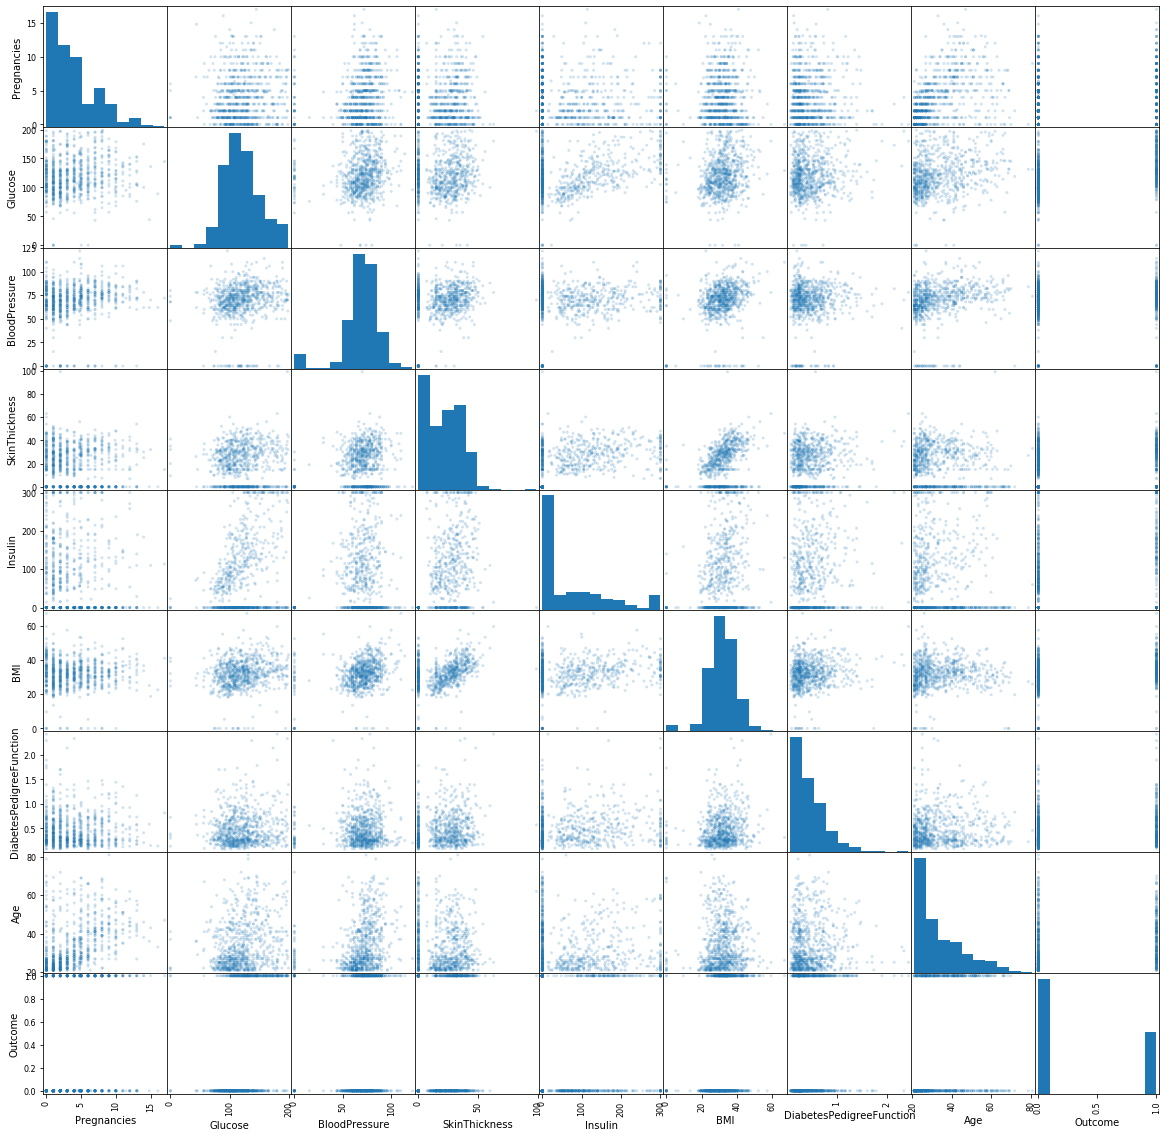

In [14]:
plot = scatter_matrix(df, alpha=0.2, figsize=(20, 20))

From the scatter matrix, we can infer that there is some linear relationship between Insulin and Glucose as well as BMI and SkinThickness. To remove redundant information from the dataset, we applied Principal Component Analysis to decrease the number of features to 7

<a id='1_pca'></a>
### Principal Component Analysis (PCA)

In [15]:
x = df.loc[:, features].values
y = df.loc[:,['Outcome']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=7)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7'])

pca_df = pd.concat([principal_df, df[['Outcome']]], axis = 1)

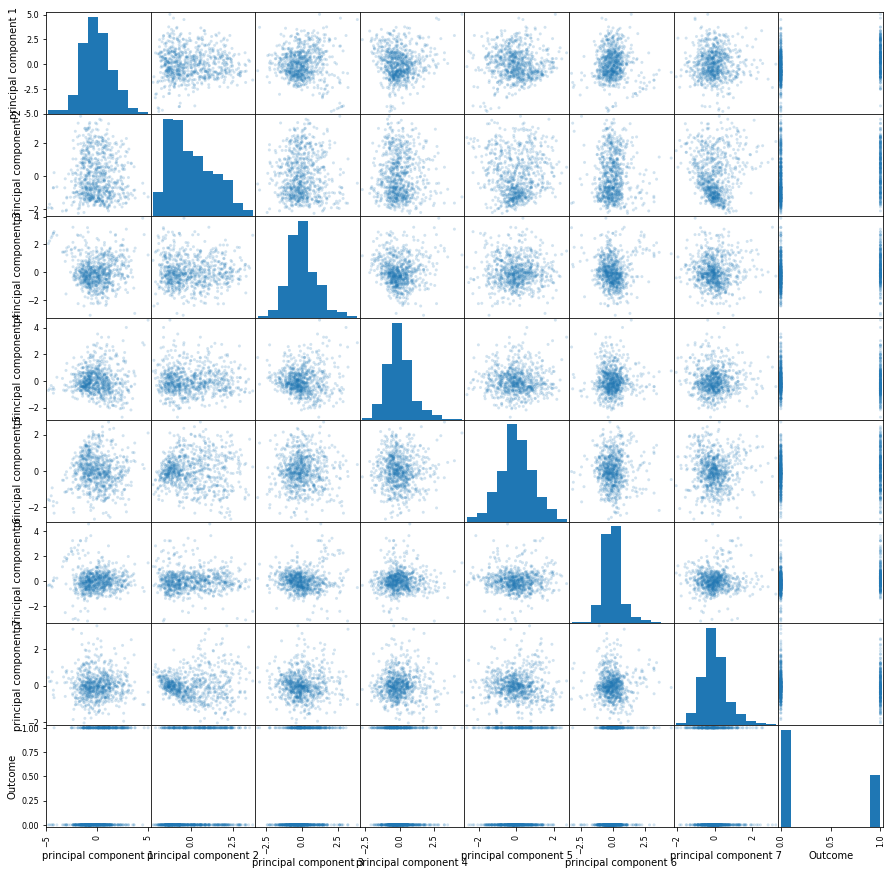

In [16]:
pca_df.describe()
plot = scatter_matrix(pca_df, alpha=0.2, figsize=(15, 15))

The new scatter matrix verifies our hypothesis of a linear relationship between some of the features and now all the components have no relation between each other and are independent.

<a id='1_model'></a>
### Model Building

The helper function `PCA_split_dataset` is used to shuffle the dataset and split it into training and validation data.

In [17]:
def PCA_split_dataset(pca_df):
    pca_df = pca_df.sample(frac=1)
    pca_X = pca_df[pca_df.columns[0:7]]
    pca_y = pca_df[pca_df.columns[7]] 
    return train_test_split(pca_X, pca_y, test_size = 0.20)

We train the data using multiple algorithm to find the model which gives the best results on this dataset.

**1. Logistic Regression**

In [18]:
lr_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = PCA_split_dataset(pca_df)
    model = LogisticRegression(max_iter=2000, solver='lbfgs',random_state=0)
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    lr_accuracy.append(accuracy_percent)

In [19]:
lr_average_accuracy = np.mean(lr_accuracy)
print("Accuracy for Logistic Regression\nAverage:",lr_average_accuracy,"\nMaximum:", max(lr_accuracy),"\nMinimum:", min(lr_accuracy))

Accuracy for Logistic Regression
Average: 77.22727272727273 
Maximum: 87.01298701298701 
Minimum: 68.18181818181817


**2. SVM**

In [20]:
svm_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = PCA_split_dataset(pca_df)
    model = SVC(kernel='linear',random_state=0)
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    svm_accuracy.append(accuracy_percent)

In [21]:
svm_average_accuracy = np.mean(svm_accuracy)
print("Accuracy using SVM\nAverage:",svm_average_accuracy,"\nMaximum:", max(svm_accuracy),"\nMinimum:", min(svm_accuracy))

Accuracy using SVM
Average: 77.02597402597404 
Maximum: 85.71428571428571 
Minimum: 66.23376623376623


**3. Naive Bayes**

In [ ]:
nb_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = PCA_split_dataset(pca_df)
    model = GaussianNB()
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    nb_accuracy.append(accuracy_percent)

In [ ]:
nb_average_accuracy = np.mean(nb_accuracy)
print("Accuracy using SVM\nAverage:",nb_average_accuracy,"\nMaximum:", max(nb_accuracy),"\nMinimum:", min(nb_accuracy))

### Comparison across different models

In [ ]:
print("Model\t\t\t Accuracy")
print("Logistic Regression\t",lr_average_accuracy)
print("SVM\t\t\t",svm_average_accuracy)
print("Naive Bayes\t\t",nb_average_accuracy)

<a id='2'></a>
## Approach 2

**Helper Function -** The function `regress_zero_values` implements Deterministic Regression Imputation for two linearly dependent features, where the `target` contains the values we're imputing. This is done using linear regression on the `feature` and `target` variables.

In [ ]:
def regress_zero_values(df, feature, target):
    zero_target_data = df[ df[target] == 0 ]
    non_zero_target_data = df[ df[target] != 0]

    train_X = non_zero_target_data[feature].values.reshape(-1,1)
    train_y = non_zero_target_data[target].values.reshape(-1,1)
    val_X = zero_target_data[feature].values.reshape(-1,1)

    model = LinearRegression()
    model.fit(train_X, train_y)
    predicted_y = model.predict(val_X)

    j = 0
    for i in df.index:
        if df.at[i, target] == 0:
            df.at[i, target] = predicted_y[j][0]
            j+=1

<a id='2_eda'></a>
### Exploratory Data Analysis

In [ ]:
plot = df.plot(x='SkinThickness', y='BMI', style='.')
y_label = plot.set_ylabel('BMI')

From the plot above, we can infer two things: 
    1. There is a linear relationship between SkinThickness and BMI. 
    2. A lot of SkinThickness values are zero but it is not possible for a person's skin thickness to be zero. 
<br>Hence we use the `regress_zero_values` helper function to impute the zero values of Insulin.

In [ ]:
regress_zero_values(df, 'BMI', 'SkinThickness')

In [ ]:
plot = df.plot(x='SkinThickness', y='BMI', style='.')
y_label = plot.set_ylabel('BMI')

Hence zero values are imputed for SkinThickness

In [ ]:
plot = df.plot(x='Insulin', y='Glucose', style='.')
y_label = plot.set_ylabel('Glucose')

From the plot above, we can infer two things: 
    1. There is a linear relationship between Insulin and Glucose. 
    2. A lot of insulin values are zero but it is not possible for a person's insulin level to fall below 16 mIU/L. 
<br>Hence we use the `regress_zero_values` helper function to impute the zero values of Insulin.

In [ ]:
regress_zero_values(df, 'Glucose', 'Insulin')

In [ ]:
plot = df.plot(x='Insulin', y='Glucose', style='.')
y_label = plot.set_ylabel('Glucose')

Hence zero values are imputed for Insulin

Normalizing data so that scale of certain features such as glucose, blood pressure and insulin do not skew the model.

In [ ]:
for feature in features:
    df[feature] = (df[feature] - df[feature].mean())/(df[feature].std())
df.describe()

<a id='2_model'></a>
### Model Building

This helper function is used to shuffle the dataset and split it into training and validation data.

In [ ]:
def split_dataset(df):
    df = df.sample(frac=1)
    X = df[df.columns[0:8]]
    y = df[df.columns[8]] 
    return train_test_split(X, y, test_size = 0.20)

We train the data using multiple algorithm to find the model which gives the best results on this dataset.

**1. Logistic Regression**

In [ ]:
lr_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = split_dataset(df)
    model = LogisticRegression(max_iter=2000, solver='lbfgs',random_state=0)
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    lr_accuracy.append(accuracy_percent)

In [ ]:
lr_average_accuracy = np.mean(lr_accuracy)
print("Accuracy for Logistic Regression\nAverage:",lr_average_accuracy,"\nMaximum:", max(lr_accuracy),"\nMinimum:", min(lr_accuracy))

**2. SVM**

In [ ]:
svm_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = split_dataset(df)
    model = SVC(kernel='linear',random_state=0)
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    svm_accuracy.append(accuracy_percent)

In [ ]:
svm_average_accuracy = np.mean(svm_accuracy)
print("Accuracy using SVM\nAverage:",svm_average_accuracy,"\nMaximum:", max(svm_accuracy),"\nMinimum:", min(svm_accuracy))

**3. Naive Bayes**

In [ ]:
nb_accuracy = []
for i in range(500):
    train_X, val_X, train_y, val_y = split_dataset(df)
    model = GaussianNB()
    model.fit(train_X, train_y)
    accuracy_percent = model.score(val_X, val_y)*100
    nb_accuracy.append(accuracy_percent)

In [ ]:
nb_average_accuracy = np.mean(nb_accuracy)
print("Accuracy using SVM\nAverage:",nb_average_accuracy,"\nMaximum:", max(nb_accuracy),"\nMinimum:", min(nb_accuracy))

### Comparison across different models

In [ ]:
print("Model\t\t\t Accuracy")
print("Logistic Regression\t",lr_average_accuracy)
print("SVM\t\t\t",svm_average_accuracy)
print("Naive Bayes\t\t",nb_average_accuracy)